In [2]:
import sys
sys.path.append('/kaggle/usr/lib')

import numpy as np
import pandas as pd
import os
import time
import h5py
from basic_preprocessing_utility_script import process_as_h5, signature
import iisignature as isig

iisignature not found. Installing...
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 23.9 MB/s eta 0:00:0000:01
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
  Created wheel for iisignature: filename=iisignature-0.24-cp310-cp310-linux_x86_64.whl size=1401821 sha256=9cc521f2b314bc0773b69982ebaa689698a333f25b8facbfa219b80e1823d5b5
  Stored in directory: /root/.cache/pip/wheels/c8/13/d1/42e1aa7f8a8e1189360df53c461f0e13f43e0d2170ef16d349
Successfully built iisignature


In [47]:
# filename = '/kaggle/input/hms-harmful-brain-activity-classification/train.csv'
# process_as_h5(filename, num_examples = 1000)

100%|██████████| 1000/1000 [00:54<00:00, 18.41it/s]


Files created!


In [3]:
hdf5_file = '/kaggle/working/hdf5/processed_dataset_1000.h5'
num_examples = 1000



with h5py.File(hdf5_file, 'r') as file:
    # List all groups
    
    print("Keys: %s" % file.keys())
    
    file_keys = list(file.keys())

    a_group_key = list(file.keys())[0]
    
    eeg_data = np.array(file[f"eeg"])
    sp_data = np.array(file[f"sp"])
    targets = np.array(file[f"targets"])
    num_votes = np.array(file[f"num_votes"])
    num_votes = num_votes.reshape((len(num_votes), -1))
    

Keys: <KeysViewHDF5 ['eeg', 'num_votes', 'sp', 'targets']>


## We try just using the EEG data

In [9]:
print(eeg_data.shape)
print(targets.shape)

(1000, 2000, 18)
(1000, 6)


## We try applying the signature across each signal

### We apply the signature across the different streams (there are 4 of length 4, and then one 'other' of length 2)

In [6]:
eeg_streams = [eeg_data[:,:,:4],  eeg_data[:,:,4:8], eeg_data[:,:,8:12], eeg_data[:,:,12:16], eeg_data[:,:,16:]]
eeg_stream_sig = [signature(stream, level=4) for stream in eeg_streams]


In [7]:
for stream in eeg_stream_sig:
    print(stream.shape)

(1000, 340)
(1000, 340)
(1000, 340)
(1000, 340)
(1000, 30)


In [8]:
eeg_sig = np.concatenate(eeg_stream_sig, axis=-1)

print(eeg_sig.shape)

(1000, 1390)


Create historgram of values in eeg_sig to see in what range values in the signautre are in

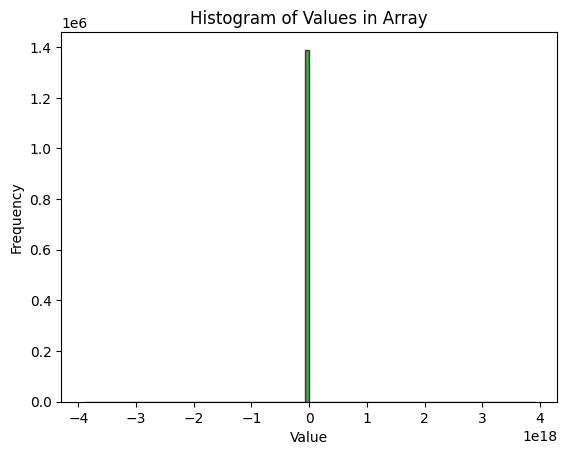

In [35]:
# Creating the histogram
plt.hist(eeg_sig.reshape(-1), bins=100, alpha=0.7, color='green', edgecolor='black')

plt.title('Histogram of Values in Array')
plt.xlabel('Value')
plt.ylabel('Frequency')

# Display the histogram
plt.show()

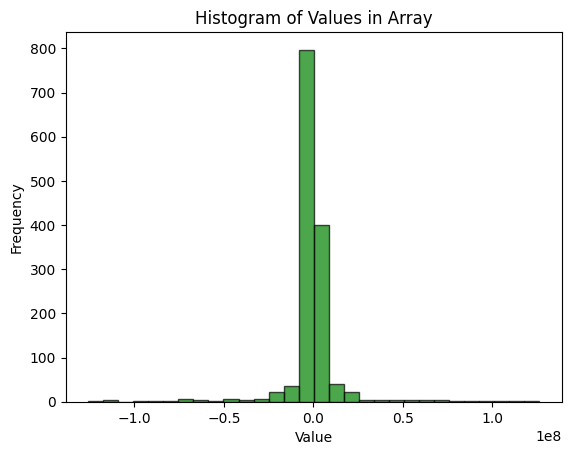

In [38]:
# Creating the histogram
plt.hist(eeg_sig[0], bins=30, alpha=0.7, color='green', edgecolor='black')

plt.title('Histogram of Values in Array')
plt.xlabel('Value')
plt.ylabel('Frequency')

# Display the histogram
plt.show()

### We clip the output of the signature to be between -0.5 and 0.5

In [40]:
eeg_sig_clip = np.clip(eeg_sig, a_min=-0.5, a_max=0.5)

In [41]:
import numpy as np
import torch
from torch.utils.data import TensorDataset, DataLoader, random_split

# Mock data
features = eeg_sig_clip
targets = targets

# Convert to PyTorch tensors
features_tensor = torch.tensor(features, dtype=torch.float32)
targets_tensor = torch.tensor(targets, dtype=torch.float32)

# Create a TensorDataset
dataset = TensorDataset(features_tensor, targets_tensor)

# Split dataset into train and test sets
train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size
train_dataset, test_dataset = random_split(dataset, [train_size, test_size])

# Create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)



import torch.nn as nn
import torch.nn.functional as F

class SimpleNN(nn.Module):
    def __init__(self):
        super(SimpleNN, self).__init__()
        self.fc1 = nn.Linear(1390, 512)  # Input layer to hidden layer
        self.fc2 = nn.Linear(512, 128)   # Hidden layer
        self.fc3 = nn.Linear(128, 6)     # Output layer

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return F.log_softmax(x, dim=1) # Ensure output sums to 1

# Initialize the model
model = SimpleNN()





In [27]:
import torch.optim as optim
import matplotlib.pyplot as plt

# Assume nn, model, train_loader, and test_loader are already defined

# Loss function and optimizer
criterion = nn.KLDivLoss(reduction='batchmean')
optimizer = optim.Adam(model.parameters(), lr=0.01)

losses = []  # List to store the average loss per epoch
test_losses = []  # List to store the average test loss per epoch

# Training loop
num_epochs = 100
for epoch in range(num_epochs):
    model.train()  # Set the model to training mode
    total_loss = 0
    for inputs, labels in train_loader:
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

    avg_loss = total_loss / len(train_loader)
    losses.append(avg_loss)

    # Evaluate on test set
    model.eval()  # Set the model to evaluation mode
    total_test_loss = 0
    with torch.no_grad():  # Disable gradient calculation for evaluation
        for inputs, labels in test_loader:
            outputs = model(inputs)
            test_loss = criterion(outputs, labels)
            total_test_loss += test_loss.item()
    
    avg_test_loss = total_test_loss / len(test_loader)
    test_losses.append(avg_test_loss)
    
    print(f"Epoch {epoch+1}, Training Loss: {avg_loss}, Test Loss: {avg_test_loss}")

Epoch 1, Training Loss: 106816380509440.0, Test Loss: 6814995504.0
Epoch 2, Training Loss: 178105124324066.47, Test Loss: 409270131968.0
Epoch 3, Training Loss: 431224784840807.4, Test Loss: 155377735456.0
Epoch 4, Training Loss: 156593729917667.7, Test Loss: 2891201792.0
Epoch 5, Training Loss: 199374639164.92307, Test Loss: 165337490082.0
Epoch 6, Training Loss: 47681415515344.62, Test Loss: 6046997565.0
Epoch 7, Training Loss: 2329418916689.231, Test Loss: 6134460620.0
Epoch 8, Training Loss: 67609204690344.0, Test Loss: 505439072.0
Epoch 9, Training Loss: 633682093313.3846, Test Loss: 17533199239.0
Epoch 10, Training Loss: 12830768347.826923, Test Loss: 395314454.0
Epoch 11, Training Loss: 10320248515898.309, Test Loss: 198539797.0
Epoch 12, Training Loss: 9052557491.692308, Test Loss: 232620756.0
Epoch 13, Training Loss: 8766253142.153847, Test Loss: 144577422.5
Epoch 14, Training Loss: 2973407402.298077, Test Loss: 116962562.5
Epoch 15, Training Loss: 1275833867.4134614, Test Los

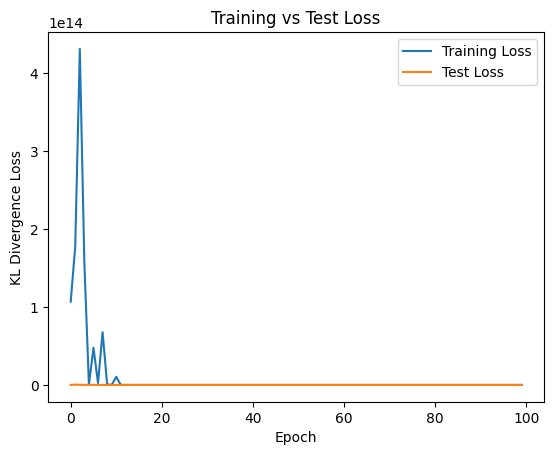

In [28]:
import matplotlib.pyplot as plt

# Plotting
plt.plot(losses, label='Training Loss')
plt.plot(test_losses, label='Test Loss')
plt.title('Training vs Test Loss')
plt.xlabel('Epoch')
plt.ylabel('KL Divergence Loss')
plt.legend()
plt.show()


In [23]:
import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader, random_split
import numpy as np

# Example data loading (replace with your actual file loading code)
num_examples = 1000  # Assuming this is defined somewhere

# Convert numpy arrays to PyTorch tensors
eeg_data_tensor = torch.Tensor(eeg_data)  # Assuming eeg_data is your input numpy array
sp_data_tensor = torch.Tensor(sp_data)    # Assuming sp_data is your input numpy array
targets_tensor = torch.Tensor(targets)    # Assuming targets is your numpy array of target probabilities

print(f"eeg_data_tensor shape: {eeg_data_tensor.shape}") # num_examples x 272
print(f"sp_data_tensor shape: {sp_data_tensor.shape}") # num_examples x  [4, 10100]
print(f"targets_tensor shape: {targets_tensor.shape}")

sp_data_tensor = sp_data_tensor.reshape((num_examples, -1))

train_size = int(0.8 * num_examples)  # 80% for training
test_size = num_examples - train_size  # Remaining 20% for testing


# Concatenate your input data along the feature dimension
inputs_tensor = torch.cat((eeg_data_tensor, sp_data_tensor), dim=1)  # Adjust dim if necessary
print(f"inputs_tensor shape: {inputs_tensor.shape}")


# Create a TensorDataset and DataLoader
dataset = TensorDataset(inputs_tensor, targets_tensor)
train_dataset, test_dataset = random_split(dataset, [train_size, test_size])

train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# Define the model
class MyModel(nn.Module):
    def __init__(self):
        super(MyModel, self).__init__()
        self.fc1 = nn.Linear(inputs_tensor.shape[1], 128)  # Adjust the input dimension as necessary
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(128, 6)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        return x

model = MyModel()

# Define loss function and optimizer
loss_function = nn.CrossEntropyLoss()  # Binary Cross Entropy Loss for binary classification
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Training loop
for epoch in range(10):  # Number of epochs
    model.train()
    for inputs, labels in train_dataloader:
        optimizer.zero_grad()
        outputs = model(inputs)
        print(f"outputs: {outputs}")
        loss = loss_function(outputs.squeeze(), labels)
        loss.backward()
        optimizer.step()
    print(f'Epoch {epoch+1}, Loss: {loss.item()}')

# Note: Add any necessary model evaluation steps here


eeg_data_tensor shape: torch.Size([1000, 272])
sp_data_tensor shape: torch.Size([1000, 4, 10100])
targets_tensor shape: torch.Size([1000, 6])
inputs_tensor shape: torch.Size([1000, 40672])
outputs: tensor([[-4.1252e+03,  4.4976e+01,  2.5592e+03, -2.0490e+03, -3.4660e+03,
          5.1249e+01],
        [-8.4228e+05,  7.4254e+05,  3.1103e+05, -1.0870e+06,  6.3859e+05,
          8.3674e+04],
        [ 1.4737e+01,  2.3081e+01,  2.7482e+00, -1.3256e+00, -3.7339e+01,
         -2.3514e+01],
        [ 2.6275e+01, -6.1183e+01,  4.2398e+02, -5.1437e+02, -3.1563e+02,
         -2.8056e+02],
        [        nan,         nan,         nan,         nan,         nan,
                 nan],
        [ 3.5045e+02,  1.5331e+01,  2.4670e+02, -5.5702e+02, -1.3566e+02,
         -3.6125e+02],
        [ 1.4032e+02,  5.1954e+01,  4.5226e+01, -3.5340e+02, -3.6218e+01,
         -2.1780e+02],
        [ 3.9504e+01, -1.2385e+02,  1.3610e+02, -7.1427e+02, -1.0596e+01,
         -2.5111e+02],
        [ 5.9841e+02,  5.2